In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import plumed
import torch
import torch.nn as nn
import torch.optim as optim

In [14]:
data=np.load('raw_data/Dialanine/Dialanine_reference_FES.npy')

phi_values = data[:,0]
psi_values = data[:,1]
file_free_values = data[:,2]

phi_grid, psi_grid = np.meshgrid(np.linspace(phi_values.min(), phi_values.max(), 100),
                                 np.linspace(psi_values.min(), psi_values.max(), 100))

file_free_grid = griddata((phi_values, psi_values), file_free_values, (phi_grid, psi_grid), method='cubic')

levels=np.arange(0,55,5)

num_bins = 11

In [15]:
class DeepLNE_CV(nn.Module):

    def __init__(self,
                ANN_layers: list,
                AutoEncoder_layers: list,
                f: int,
                d: int,
                n: int,
                ref: torch.Tensor,
                ref_z: torch.Tensor,
                act: str,
                z_lambda: float):
        

        super(DeepLNE_CV,self).__init__()
        
        # =======   LOSS  =======
        self.loss_mse = torch.nn.MSELoss()
        

        # ======= BLOCKS =======
        
        self.n_features=f
        self.n_neighbors=n
        self.d_metric=d
        self.training_datapoints=ref
        self.training_datapoints_z=ref_z
        self.z_lambda=z_lambda
        
        print('Numer of input features:',self.n_features)
        print('Numer of neighbors:',self.n_neighbors)
        print('Dimension for nn search:',self.d_metric)
         
        if act == 'ReLU':
            self.activationf=torch.nn.ReLU()
        if act == 'Tanh':
            self.activationf=torch.nn.Tanh()
        if act == 'Sigmoid':
            self.activationf=torch.nn.Sigmoid()
        if act == 'ELU':
            self.activationf=torch.nn.ELU()
        
        self.ANNlayers = []
        
        self.ANNlayers.append(torch.nn.Linear(self.n_features, ANN_layers[0]))
        self.ANNlayers.append(self.activationf)
        
        for i in range(len(ANN_layers) - 1):
            self.ANNlayers.append(torch.nn.Linear(ANN_layers[i], ANN_layers[i + 1]))
            self.ANNlayers.append(self.activationf)

        self.ANNlayers.append(torch.nn.Linear(ANN_layers[-1], self.d_metric))
        
        self.metric = torch.nn.Sequential(*self.ANNlayers)
        print('ANN architecture: ',self.metric)
            

        # initialize encoder
        self.AutoEncoderLayers = []
        
        self.AutoEncoderLayers.append(torch.nn.Linear(int(self.n_neighbors*self.d_metric), AutoEncoder_layers[0]))
        self.AutoEncoderLayers.append(self.activationf)
        
        for i in range(len(AutoEncoder_layers) - 1):
            self.AutoEncoderLayers.append(torch.nn.Linear(AutoEncoder_layers[i], AutoEncoder_layers[i + 1]))
            self.AutoEncoderLayers.append(self.activationf)

        self.AutoEncoderLayers.append(torch.nn.Linear(AutoEncoder_layers[-1], 1))
        self.AutoEncoderLayers.append(torch.nn.Sigmoid())

        self.encoder = torch.nn.Sequential(*self.AutoEncoderLayers)
        print('Encoder architecture: ',self.encoder)
        
        # initialize decoder
        self.AutoDecoderLayers = []
        AutoDecoder_layers=AutoEncoder_layers[::-1]
        
        self.AutoDecoderLayers.append(torch.nn.Linear(1, AutoDecoder_layers[0]))
        self.AutoDecoderLayers.append(self.activationf)
        
        for i in range(len(AutoDecoder_layers) - 1):
            self.AutoDecoderLayers.append(torch.nn.Linear(AutoDecoder_layers[i], AutoDecoder_layers[i + 1]))
            self.AutoDecoderLayers.append(self.activationf)

        self.AutoDecoderLayers.append(torch.nn.Linear(AutoDecoder_layers[-1], self.n_features))

        self.decoder = torch.nn.Sequential(*self.AutoDecoderLayers)
        print('Decoder architecture: ',self.decoder)
    
    def softmax_w(self,x: torch.Tensor, t=1e-1) -> torch.Tensor:
        x = x / t
        x = x - torch.max(x, dim=1, keepdim=True)[0]
        return (torch.exp(x)+1e-4) / torch.sum(torch.exp(x), dim=1, keepdim=True)
        

    def soft_top_k(self,x: torch.Tensor,t: torch.Tensor) -> torch.Tensor:
        y = torch.zeros_like(x)
        
        x_w = x * (1 - y)
        x_w_softmax = self.softmax_w(x_w)
        y = y+x_w_softmax
            
        for k in range(self.n_neighbors):
            x_w = x * (1 - y)
            x_w_softmax = self.softmax_w(x_w)
            y = y+x_w_softmax
            
            dm=torch.matmul(t.T,x_w_softmax.T)
            
            if k == 0:
                dn=dm
            else:
                dn=torch.cat((dn,dm))
        return dn.T

    def learn_metric(self,x: torch.Tensor) -> torch.Tensor:
        d=self.metric(x)
        t=self.metric(self.training_datapoints)
        return d,t
    
    def find_nearest_neighbors(self,x: torch.Tensor,t: torch.Tensor) -> torch.Tensor:
        
        dist = torch.cdist(x, t)
        dist=torch.exp(-dist)
        dn = self.soft_top_k(dist,t)
        
        return dn
        
    def encode(self,x: torch.Tensor) -> torch.Tensor:
        x=self.encoder(x)
        return x
    
    def decode(self,x: torch.Tensor) -> torch.Tensor:
        x=self.decoder(x)
        return x
    
    def encode_decode(self, x: torch.Tensor) -> torch.Tensor:
        d,t=self.learn_metric(x)
        dn=self.find_nearest_neighbors(d,t)
        
        s=self.encode(dn)
        x_hat=self.decode(s) 
        
        return x_hat,s,d,dn
    
    def forward(self, x: torch.Tensor) -> torch.Tensor :
        d,t=self.learn_metric(x)
        dn=self.find_nearest_neighbors(d,t)
        s=self.encode(dn).reshape(-1,1)
        z=self.compute_z(x).reshape(-1,1)
        
        out=torch.hstack((s,z))
        
        return out
    
    def compute_z(self,x: torch.Tensor) -> torch.Tensor:
        z_dist=torch.cdist(x,self.training_datapoints_z)
        z_dist=torch.absolute(z_dist)
        z=(-1/self.z_lambda)*torch.log(torch.sum(torch.exp(-self.z_lambda*z_dist),axis=1))

        return z

Numer of input features: 190
Numer of neighbors: 3
Dimension for nn search: 3
ANN architecture:  Sequential(
  (0): Linear(in_features=190, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=24, bias=True)
  (3): Tanh()
  (4): Linear(in_features=24, out_features=3, bias=True)
)
Encoder architecture:  Sequential(
  (0): Linear(in_features=9, out_features=24, bias=True)
  (1): Tanh()
  (2): Linear(in_features=24, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)
Decoder architecture:  Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=24, bias=True)
  (3): Tanh()
  (4): Linear(in_features=24, out_features=190, bias=True)
)
Numer of input features: 190
Numer of neighbors: 3
Dimension for nn search: 3
ANN architecture:  Sequential(
  (0): Linear(in_features=190, out_features=50, bias=True)
  (1): Tanh()
  (2): Linea

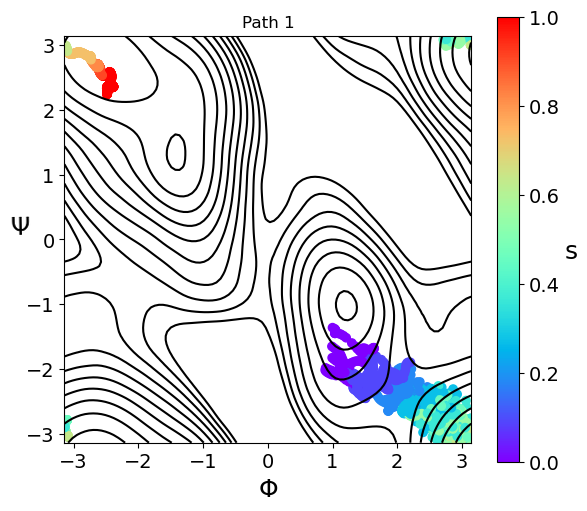

<Figure size 640x480 with 0 Axes>

Numer of input features: 190
Numer of neighbors: 3
Dimension for nn search: 3
ANN architecture:  Sequential(
  (0): Linear(in_features=190, out_features=10, bias=True)
  (1): Tanh()
  (2): Linear(in_features=10, out_features=3, bias=True)
)
Encoder architecture:  Sequential(
  (0): Linear(in_features=9, out_features=24, bias=True)
  (1): Tanh()
  (2): Linear(in_features=24, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)
Decoder architecture:  Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=24, bias=True)
  (3): Tanh()
  (4): Linear(in_features=24, out_features=190, bias=True)
)
Numer of input features: 190
Numer of neighbors: 3
Dimension for nn search: 3
ANN architecture:  Sequential(
  (0): Linear(in_features=190, out_features=10, bias=True)
  (1): Tanh()
  (2): Linear(in_features=10, out_features=3, bias=True)
)
Encoder architecture:  Se

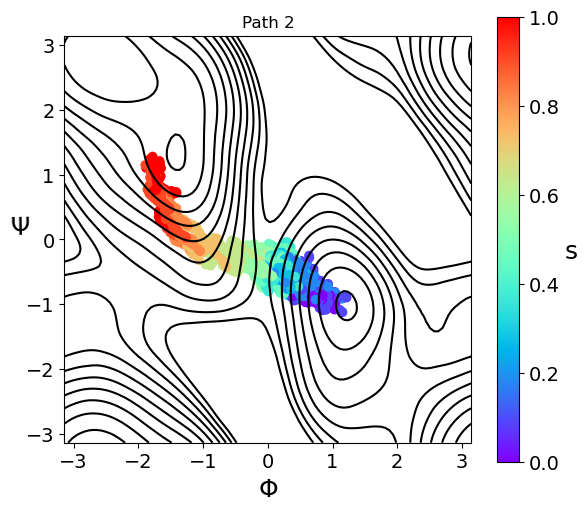

<Figure size 640x480 with 0 Axes>

Numer of input features: 190
Numer of neighbors: 3
Dimension for nn search: 3
ANN architecture:  Sequential(
  (0): Linear(in_features=190, out_features=10, bias=True)
  (1): Tanh()
  (2): Linear(in_features=10, out_features=3, bias=True)
)
Encoder architecture:  Sequential(
  (0): Linear(in_features=9, out_features=24, bias=True)
  (1): Tanh()
  (2): Linear(in_features=24, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)
Decoder architecture:  Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=24, bias=True)
  (3): Tanh()
  (4): Linear(in_features=24, out_features=190, bias=True)
)
Numer of input features: 190
Numer of neighbors: 3
Dimension for nn search: 3
ANN architecture:  Sequential(
  (0): Linear(in_features=190, out_features=10, bias=True)
  (1): Tanh()
  (2): Linear(in_features=10, out_features=3, bias=True)
)
Encoder architecture:  Se

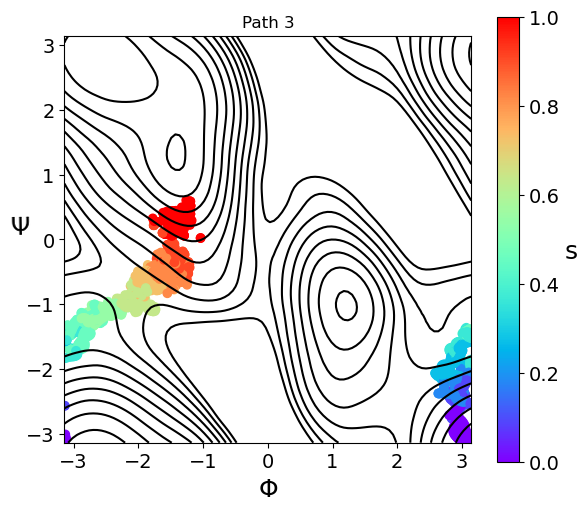

<Figure size 640x480 with 0 Axes>

In [27]:
for i in range(1,4):
    if i ==1:
        training_datapoints=torch.Tensor(np.load('raw_data/Dialanine/Path1_training_datapoints.npy'))
        training_datapoints_plot=np.load('raw_data/Dialanine/Path1_training_training_datapoints_plot.npy')
        model_datapoints=torch.Tensor(np.load('raw_data/Dialanine/Path1_neighbours.npy'))

        ANN_architecture=[50,24]
        AutoEncoder_architecture=[24,16]

    if i ==2:
    
        training_datapoints=torch.Tensor(np.load('raw_data/Dialanine/Path2_training_datapoints.npy'))
        training_datapoints_plot=np.load('raw_data/Dialanine/Path2_training_training_datapoints_plot.npy')
        model_datapoints=torch.Tensor(np.load('raw_data/Dialanine/Path2_neighbours.npy'))


        ANN_architecture=[10]
        AutoEncoder_architecture=[24,16]
        
    if i ==3:
        
        training_datapoints=torch.Tensor(np.load('raw_data/Dialanine/Path3_training_datapoints.npy'))
        training_datapoints_plot=np.load('raw_data/Dialanine/Path3_training_training_datapoints_plot.npy')
        model_datapoints=torch.Tensor(np.load('raw_data/Dialanine/Path3_neighbours.npy'))


        ANN_architecture=[10]
        AutoEncoder_architecture=[24,16]
        
    n_features=190
    d_metric=3
    n_neighbors=3
    l=10

    model = DeepLNE_CV(ANN_layers=ANN_architecture,
                       AutoEncoder_layers=AutoEncoder_architecture,
                       f=n_features,
                       d=d_metric,
                       n=n_neighbors,
                       ref=model_datapoints,
                       ref_z=model_datapoints,
                       act='Tanh',
                       z_lambda=l)

    device = torch.device("cpu")
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.load_state_dict(torch.load('raw_data/Dialanine/Path%s_model_params_DeepLNE.pt' %i), strict=False)
    
    model_datapoints_z=model.encode_decode(model_datapoints)[0].detach().numpy()

    training_datapoints=torch.Tensor(training_datapoints)
    model_datapoints=torch.Tensor(model_datapoints)
    model_datapoints_z=torch.Tensor(model_datapoints_z)

    plumed_model = DeepLNE_CV(ANN_layers=ANN_architecture,
                       AutoEncoder_layers=AutoEncoder_architecture,
                       f=n_features,
                       d=d_metric,
                       n=n_neighbors,
                       ref=model_datapoints,
                       ref_z=model_datapoints_z,
                       act='Tanh',
                       z_lambda=l)

    plumed_model.load_state_dict(torch.load('raw_data/Dialanine/Path%s_model_params_DeepLNE.pt' %i), strict=False)
    
    input=training_datapoints

    out=model(input)
    s=out[:,0]
    s=s.detach().numpy()
    
    hist, bin_edges = np.histogram(s, bins=num_bins, range=(s.min(), s.max()))
    bin_indices = np.digitize(s, 0.5*(bin_edges[1:]+bin_edges[:-1]))/num_bins
    
    fig, ax = plt.subplots(1, figsize=(6,6), dpi=100)
    plt.title('Path %s' %i)
    
    plt.contour(phi_grid, psi_grid,file_free_grid,levels,colors='black')
    plt.scatter(training_datapoints_plot[:, 0], training_datapoints_plot[:, -1], c=bin_indices, alpha=1, cmap='rainbow')
    
    cbar =plt.colorbar(shrink=0.8)


    cbar.set_label('s', rotation=0, labelpad=8,fontsize=18)
    cbar.ax.tick_params(labelsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel(r'$\Phi$',fontsize=18)
    plt.ylabel(r'$\Psi$', rotation=1,fontsize=18)
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()


    plt.tight_layout()
    plt.show()

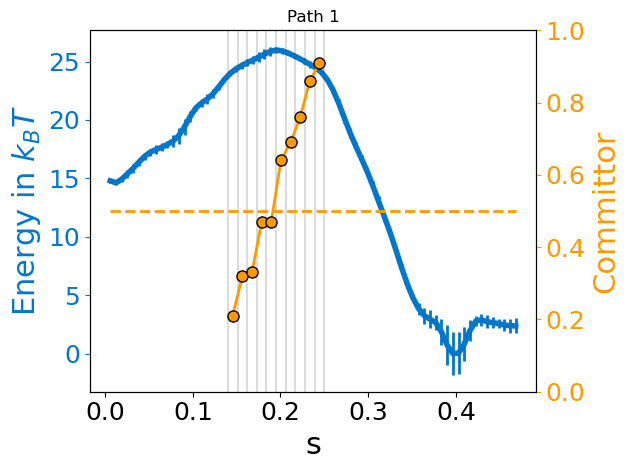

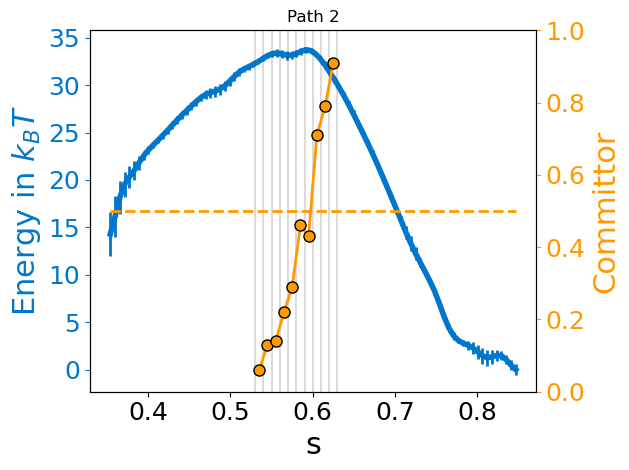

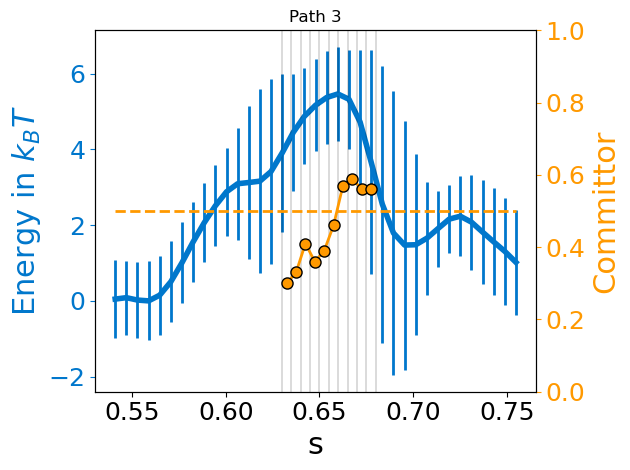

In [28]:
for i in range(1,4):
    data=np.load("raw_data/Dialanine/Path%s_FES_estimator.npy" %i)
    stateB_counter_list=np.load("raw_data/Dialanine/Path%s_committor.npy" %i)
    if i == 1:
        start = 0.14
        end = 0.25
        ndx=np.where(data[:,0]<=0.47)[0]
    if i == 2:
        start = 0.53 
        end = 0.63 
        ndx=np.where((data[:,0]>=0.35) & (data[:,0]<=0.85))[0]
        stateB_counter_list=1-stateB_counter_list
    if i == 3:
        start = 0.63 
        end = 0.68
        ndx=np.where((data[:,0]>=0.54) & (data[:,0]<=0.76))[0]
        stateB_counter_list=1-stateB_counter_list
        
    resolution = 10

    bin_edges = np.linspace(start, end, resolution + 1)

    fig = plt.figure()
    plt.title('Path %s' %i)
    plt.errorbar(data[:,0][ndx], data[:,1][ndx]-np.min(data[:,1][ndx]), yerr=data[:,2][ndx], color='#0077cc',linewidth=2)
    plt.plot(data[:,0][ndx], data[:,1][ndx]-np.min(data[:,1][ndx]), color='#0077cc',linewidth=4)

    plt.ylabel(r'Energy in $k_BT$', color='#0077cc',fontsize=22)
    plt.xlabel('s',fontsize=22)

    plt.tick_params(axis='y', colors='#0077cc')
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)


    for bin_edge in bin_edges:
        plt.axvline(x=bin_edge, color='black', linestyle='-', linewidth=0.2)

    # Create a twin Axes for the second y-axis
    ax2 = plt.gca().twinx()

    # Plot the second data on the second y-axis
    ax2.plot(0.5 * bin_edges[1:] + 0.5 * bin_edges[:-1], 1 - np.array(stateB_counter_list),'o-',color='#ff9900',markersize=8,linewidth=2,markeredgecolor='k')
    ax2.hlines(0.5,np.min(data[:,0][ndx]),np.max(data[:,0][ndx]),color='#ff9900',linewidth=2,linestyle='dashed')


    ax2.set_ylabel('Committor', color='#ff9900',fontsize=22)
    ax2.tick_params(axis='y', colors='#ff9900',labelsize=18)
    #plt.xlim(-0.02,0.49)
    ax2.set_ylim(0,1)
    plt.tight_layout()
    plt.show()

In [31]:
colvar.shape

(1000001, 9)

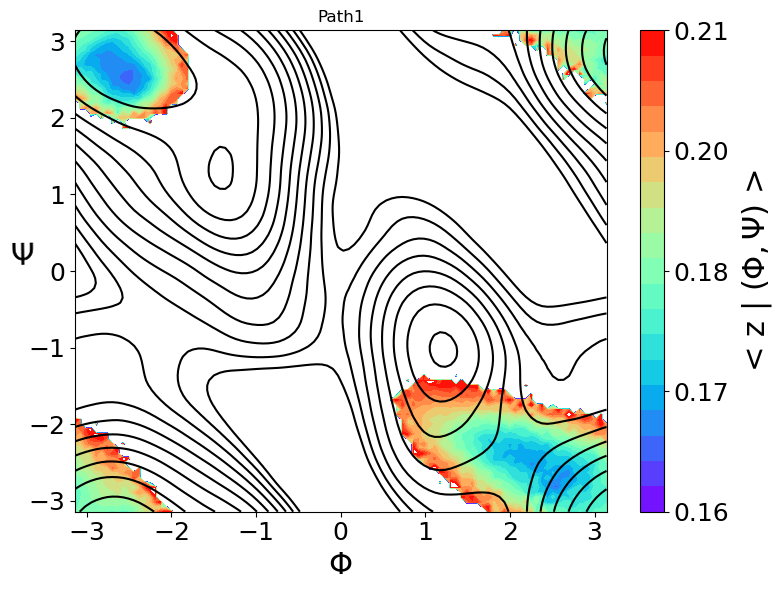

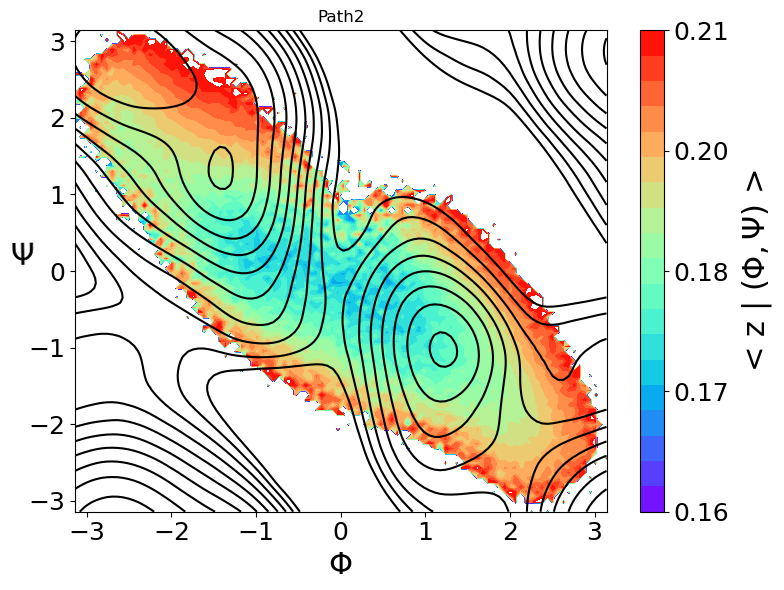

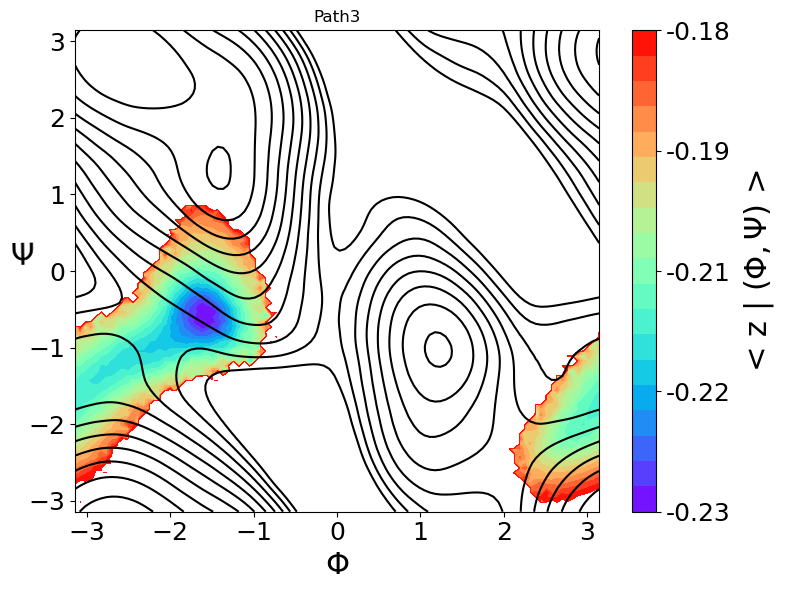

In [32]:

nbins_phi = 100
nbins_psi = 100


for i in range(1,4):
    
    colvar=np.load('raw_data/Dialanine/Path%s_Dialanine_DeepLNE_OneOPES_FES.npy'  %i)
    
    PHI = colvar[:,2]
    PSI = colvar[:,3]
    z = colvar[:,7]

    
    hist_2d, xedges, yedges = np.histogram2d(PHI, PSI, bins=(nbins_phi, nbins_psi))

    hist_weighted_2d, _, _ = np.histogram2d(PHI, PSI, bins=(nbins_phi, nbins_psi), weights=z)

    hist_2d[hist_2d == 0] = 1

    expectation_value_z = hist_weighted_2d / hist_2d

    if i==1:
        contour_levels = np.linspace(0.16, 0.21, 20) 
       
    if i==2:
        contour_levels = np.linspace(0.16,  0.21, 20)
        
    if i==3:
        contour_levels = np.linspace(expectation_value_z.min(), -0.18, 20) 
        
    fig, ax = plt.subplots(1, figsize=(8,6))
    plt.title('Path%s' %i)
    plt.contour(phi_grid, psi_grid,file_free_grid,levels,colors='black')
    contour = plt.contourf(phi_grid, psi_grid, expectation_value_z.T, levels=contour_levels, cmap='rainbow')
    
    
    cbar = plt.colorbar(contour, format='%.2f')
    cbar.set_label(r'< z | ($\Phi,\Psi$) >', rotation=90, labelpad=8,fontsize=22)
    cbar.set_ticks(np.linspace(contour_levels.min(), contour_levels.max(), 5))
    cbar.ax.tick_params(labelsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel(r'$\Phi$',fontsize=22)
    plt.ylabel(r'$\Psi$', rotation=1,fontsize=22)
    plt.tight_layout()
    plt.show()

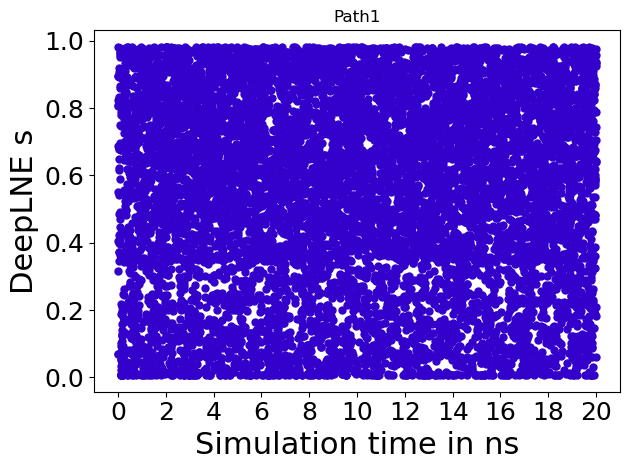

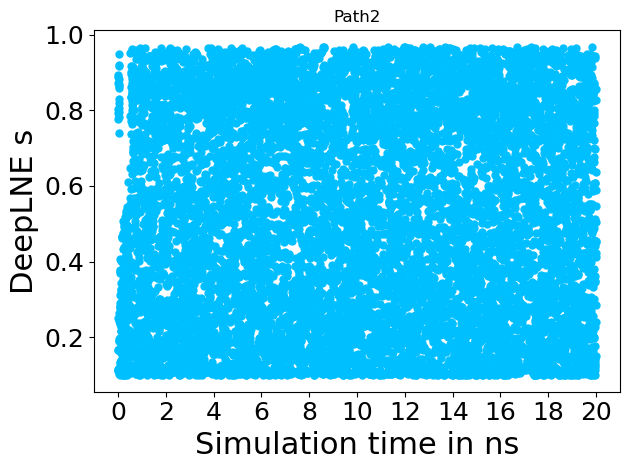

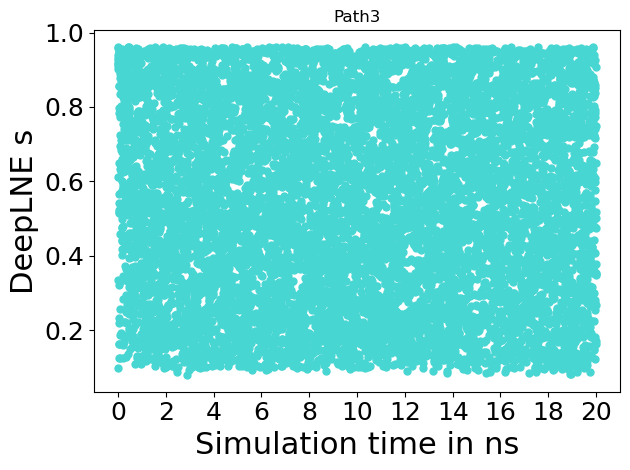

In [37]:
from matplotlib.ticker import MaxNLocator, MultipleLocator

for i in range(1,4):
    
    if i == 1:
        color='#3300CC'
        
    if i == 2:
        color='#00BFFF'
        
    if i == 3:
        color='#48D6D2'
    
    colvar=np.load('raw_data/Dialanine/Path%s_Dialanine_DeepLNE_OneOPES_FES.npy'  %i)
    
    t=np.linspace(0,10000000*0.002/1000, num=1000001)

    fig=plt.figure()
    plt.title('Path%s' %i)
    plt.plot(t[::100],colvar[:,6][::100],'.',color=color,markersize=10,alpha=1)
    plt.xlabel(r'Simulation time in ns',fontsize=22)
    plt.ylabel(r'DeepLNE s',fontsize=22)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().xaxis.set_major_locator(MultipleLocator(base=2))
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_759354/1859701924.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(top_10_names,fontsize=18)


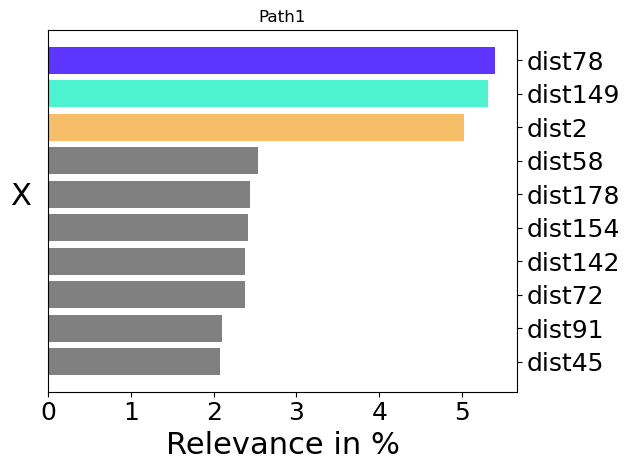

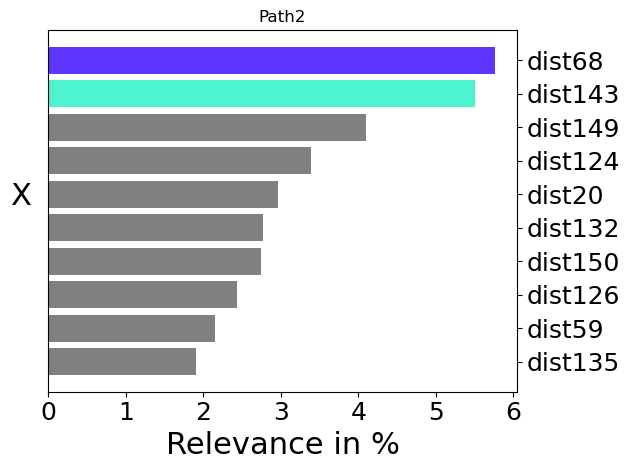

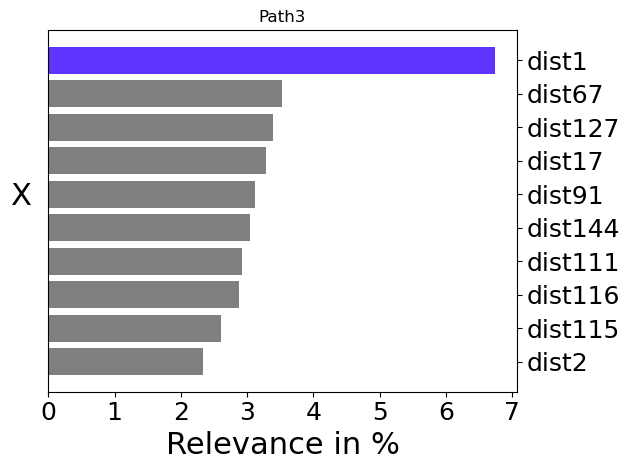

In [49]:
for i in range(1,4):
    rank=np.load('raw_data/Dialanine/Path%s_Dialanine_DeepLNE_feature_rank.npy' %i)
    input_names=np.load('raw_data/Dialanine/Path%s_Dialanine_DeepLNE_input_names.npy' %i,allow_pickle=True)
    in_num=np.load('raw_data/Dialanine/Path%s_Dialanine_DeepLNE_feature_in_num.npy' %i)

    cmap = plt.colormaps.get_cmap('rainbow')

    if i==1:
        color1 =cmap((0+0.2)/3)
        color2 =cmap((1+0.2)/3)
        color3 =cmap((2+0.2)/3)
        color4 = 'gray' 
        
        bar_colors = [color1] +[color2] +[color3] + [color4] * 7
    
    
    if i==2:
        color1 =cmap((0+0.2)/3)
        color2 =cmap((1+0.2)/3)
        color4 = 'gray' 
        
        bar_colors = [color1] +[color2]  + [color4] * 8
    
    
    if i==3:
        color1 =cmap((0+0.2)/3)
        color4 = 'gray' 
        
        bar_colors = [color1] + [color4] * 9
    
    
    sorted_indices = np.argsort(rank)[::-1]  
    top_10_indices = sorted_indices[:10]  

    top_10_names = [input_names[i] for i in top_10_indices]
    top_10_ranks = rank[top_10_indices]
    top_10_in_num = in_num[top_10_indices]


    fig=plt.figure()
    
    ax = fig.add_subplot(111)
    ax.set_title('Path%s' %i)
    ax.barh(top_10_in_num, top_10_ranks*100, color=bar_colors, linewidth=0.3)

    ax.set_yticklabels(top_10_names,fontsize=18)

    ax.set_xlabel(r'Relevance in %',fontsize=22)
    ax.set_ylabel('X',rotation=0,fontsize=22, labelpad=20)
    ax.set_yticks(top_10_in_num)
    ax.yaxis.tick_right()
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    plt.tight_layout()
    plt.show()